In [1]:
%pylab inline
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


ScatteredCube(low=array([0, 2]), high=array([-2, -3]), base=Sobol())


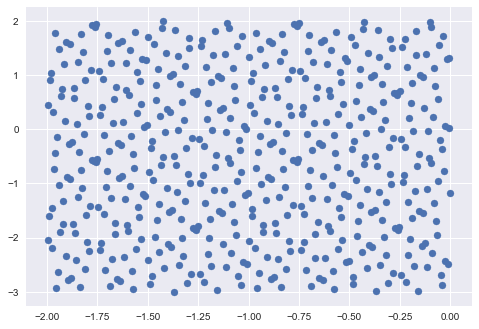

In [76]:
from nengo.dists import Distribution

from nengolib.stats.ntmdists import Sobol

class ScatteredCube(Distribution):

    def __init__(self, low=-1, high=+1, base=Sobol()):
        super(ScatteredCube, self).__init__()
        self.low = np.atleast_1d(low)
        self.high = np.atleast_1d(high)
        self.w = self.high - self.low
        self.base = base

    def __repr__(self):
        return "%s(low=%r, high=%r, base=%r)" % (
            self.__class__.__name__, self.low, self.high, self.base)

    def sample(self, num, d=None, rng=np.random):
        num, d = self._sample_shape(num, d)
        u = self.base.sample(num, d)

        # shift everything by the same random constant (with wrap-around)
        u = (u + rng.uniform(size=d)[None, :]) % 1.0

        return u * self.w[None, :] + self.low[None, :]

c = ScatteredCube([0, 2], [-2, -3])
print c
# base=Uniform(0, 1)
pylab.figure()
pylab.scatter(*c.sample(500, 2).T)
pylab.show()

In [132]:
import nengo
from nengo.base import ObjView
from nengo.dists import Choice

from nengolib.network import Network

class EnsembleCube(ObjView):

    def __init__(self, n_neurons, dimensions, half_width=1,
                 eval_points=ScatteredCube(), **ens_kwargs):

        self.n_neurons = n_neurons
        self.dimensions = dimensions
        self.half_width = half_width
        self.eval_points = eval_points  # scaled by half_width

        for illegal in ('radius', 'encoders'):
            if illegal in ens_kwargs:
                raise ValueError("do not supply '%s' keyword argument" % illegal)

        I = np.eye(dimensions)
        self.encoders = Choice(np.vstack([I, -I]))  # gain scaled by half_width

        self._state = nengo.Ensemble(
            n_neurons,
            self.dimensions,
            radius=self.half_width,
            encoders=self.encoders,
            eval_points=self.eval_points,
            **ens_kwargs)

        '''try:
            self.n_neurons = n_neurons
        except AttributeError:  # nengo>=2.4.1
            assert self.n_neurons == n_neurons'''

        # Trick to make connecting in/out more convenient
        super(EnsembleCube, self).__init__(obj=self._state)


with Network() as model:

    cube = EnsembleCube(2000, 2, half_width=20)

    process = nengo.processes.PresentInput(
        cube.half_width * cube.eval_points.sample(15, cube.dimensions), 0.1)
    function = lambda x: (x[0] - x[1])**2 + 2*x[0]*x[1]

    stim = nengo.Node(output=process)
    nengo.Connection(stim, cube, synapse=None)
    p_stim = nengo.Probe(stim, synapse=0.005)
    p_output = nengo.Probe(cube, synapse=0.005)
    
    decoded = nengo.Node(size_in=1)
    nengo.Connection(cube, decoded, function=function, synapse=None)
    p_decoded = nengo.Probe(decoded, synapse=0.02)

with nengo.Simulator(model) as sim:
    sim.run(len(stim.output.inputs)*stim.output.presentation_time)

Building finished in 0:00:07.                                                   ##############         Building... 25%                        ] ETA: 0:00:02
Simulating finished in 0:00:03.                                                 


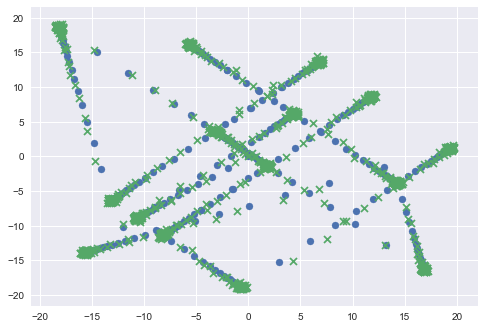

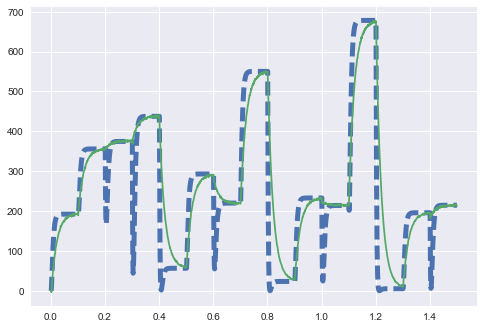

In [133]:
pylab.figure()
pylab.scatter(*sim.data[p_stim].T)
pylab.scatter(*sim.data[p_output].T, marker='x')
pylab.show()

pylab.figure()
pylab.plot(sim.trange(), [function(x) for x in sim.data[p_stim]], lw=5, linestyle='--')
pylab.plot(sim.trange(), sim.data[p_decoded])
pylab.show()

In [70]:
with nengo.Network() as model:
    array = nengo.networks.EnsembleArray(100, 2)
    print array.n_neurons
    print model.n_neurons

200
200


In [131]:
from nengo.utils.numpy import rmse, rms
ideal = np.asarray([function(x) for x in sim.data[p_stim]])
print rmse(ideal, sim.data[p_decoded])
print rms(ideal)

255.562742607
312.735563118
